<a href="https://colab.research.google.com/github/MonkeyWrenchGang/MGTPython/blob/main/module_9/9_3_TermDocumentSentiment_pt3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis Part 3


---

In parts 1 and 2 we looked at lexicon based sentiment. Lexicon based sentiemnt works great for a variety of tasks but often misses the nuances of language ~ like sarcasim. In this notebook we are going to look at a specific use case and pre-trained model twitter-XLM-roBERTa-base for Sentiment Analysis. 

This is a multilingual model trained on **~198M tweets** and finetuned for sentiment analysis. The sentiment fine-tuning was done on 8 languages (Ar, En, Fr, De, Hi, It, Sp, Pt) but it can be used for more languages (see paper for details).



NOTE: 

> CHANGE RUNTIME TYPE to GPU!!! 

Runtime > Change runtime type > Hardware Accelerator > GPU 



In [ ]:
# install huggingface and transfomers 
!pip install --upgrade transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# standard libries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import string
import re

# text libraries
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.util import ngrams
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud


# BERT and ALBERT STUFF!!! 
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AlbertTokenizer, AlbertForSequenceClassification




# Download our Parser, stopwords, and sentiment mapping


---



In [ ]:
# download nltk datasets
nltk.download('sentiwordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data


---

Today's data comes from SpaceX, POTUS, and AOC's twitter feeds! Let's dive in and take a look! 

In [ ]:
spacex = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_9/data/SpaceX_tweets_4.6.2023.csv")\
[["created_at","id_str","full_text","source"]]
spacex["created_at"] = pd.to_datetime(spacex["created_at"] )
spacex.head()



,created_at,id_str,full_text,source
0,2023-04-05 23:24:22+00:00,1643756494448635904,"Targeting Friday, April 7 for a Falcon 9 launc...","<a href=""https://mobile.twitter.com"" rel=""nofo..."
1,2023-04-02 19:22:20+00:00,1642608420560994304,Falcon 9 launches the @SemperCitiusSDA Tranche...,"<a href=""https://mobile.twitter.com"" rel=""nofo..."
2,2023-04-02 14:37:37+00:00,1642536772134658048,Falcon 9’s first stage has landed on Landing Z...,"<a href=""https://www.twitter.com/"" rel=""nofoll..."
3,2023-04-02 14:30:16+00:00,1642534920399597568,Liftoff! https://t.co/5c215blpg7,"<a href=""https://www.twitter.com/"" rel=""nofoll..."
4,2023-04-02 14:17:09+00:00,1642531621210562560,Watch Falcon 9 launch the @SemperCitiusSDA Tra...,"<a href=""https://studio.twitter.com"" rel=""nofo..."


In [ ]:
potus = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_9/data/JoeBiden_tweets_4.6.2023.csv")\
[["created_at","id_str","full_text","source"]]
potus["created_at"] = pd.to_datetime(potus["created_at"] )
potus.head()

,created_at,id_str,full_text,source
0,2023-04-06 01:10:21+00:00,1643783165465579520,I will not let MAGA Republicans undo the progr...,"<a href=""https://sproutsocial.com"" rel=""nofoll..."
1,2023-04-05 23:30:04+00:00,1643757930582294530,"To the Jewish community, I want you to know th...","<a href=""https://sproutsocial.com"" rel=""nofoll..."
2,2023-04-05 21:38:21+00:00,1643729813448929281,"Congress, pass the assault weapons ban. https:...","<a href=""https://sproutsocial.com"" rel=""nofoll..."
3,2023-04-05 18:28:01+00:00,1643681914690183173,"Let us join hands across faiths, races, and ba...","<a href=""https://sproutsocial.com"" rel=""nofoll..."
4,2023-04-05 15:57:01+00:00,1643643915650711552,We passed the most aggressive economic recover...,"<a href=""https://sproutsocial.com"" rel=""nofoll..."


In [ ]:
aoc = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_9/data/AOC_tweets_4.6.2023.csv")\
[["created_at","id_str","full_text","source"]]
aoc["created_at"] = pd.to_datetime(aoc["created_at"] )
aoc.head()

,created_at,id_str,full_text,source
0,2023-04-06 13:49:31+00:00,1643974216696442880,This is beyond party or partisanship. This deg...,"<a href=""http://twitter.com/download/iphone"" r..."
1,2023-04-06 01:50:20+00:00,1643793229052100613,If a petty HOA complaint were a person https:/...,"<a href=""http://twitter.com/download/iphone"" r..."
2,2023-04-06 01:21:34+00:00,1643785991004598273,Wishing all our Jewish neighbors in NY-14 and ...,"<a href=""http://twitter.com/download/iphone"" r..."
3,2023-04-05 02:57:58+00:00,1643447859457544192,He is publicly intimidating a judge and pointi...,"<a href=""http://twitter.com/download/iphone"" r..."
4,2023-04-04 19:48:35+00:00,1643339805147779072,Because nothing says “innocent” like threateni...,"<a href=""http://twitter.com/download/iphone"" r..."


# Download XLM roBERTa 


---

Here we are going to downloadn and configure a function for predicting sentimernt 



In [ ]:
from transformers import pipeline
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
sentiment_task("T'estimo!")

[{'label': 'positive', 'score': 0.6600585579872131}]

In [ ]:
sentiment_task("i'm scared i've never been so nervous")

[{'label': 'negative', 'score': 0.8999204039573669}]

# Prediction on all of SpaceX 


---



In [ ]:
spacex["sentiment_prediction"] = spacex['full_text'].apply(sentiment_task)

In [ ]:
# define lambda functions to extract label and score
extract_label = lambda x: x[0]['label']
extract_score = lambda x: x[0]['score']


# apply lambda functions to create new columns
spacex['label'] = spacex['sentiment_prediction'].apply(extract_label)
spacex['score'] = spacex['sentiment_prediction'].apply(extract_score)

spacex.head()

,created_at,id_str,full_text,source,sentiment_prediction,label,score
0,2023-04-05 23:24:22+00:00,1643756494448635904,"Targeting Friday, April 7 for a Falcon 9 launc...","<a href=""https://mobile.twitter.com"" rel=""nofo...","[{'label': 'neutral', 'score': 0.8132233023643...",neutral,0.813223
1,2023-04-02 19:22:20+00:00,1642608420560994304,Falcon 9 launches the @SemperCitiusSDA Tranche...,"<a href=""https://mobile.twitter.com"" rel=""nofo...","[{'label': 'neutral', 'score': 0.7439560294151...",neutral,0.743956
2,2023-04-02 14:37:37+00:00,1642536772134658048,Falcon 9’s first stage has landed on Landing Z...,"<a href=""https://www.twitter.com/"" rel=""nofoll...","[{'label': 'neutral', 'score': 0.8247161507606...",neutral,0.824716
3,2023-04-02 14:30:16+00:00,1642534920399597568,Liftoff! https://t.co/5c215blpg7,"<a href=""https://www.twitter.com/"" rel=""nofoll...","[{'label': 'neutral', 'score': 0.7669990658760...",neutral,0.766999
4,2023-04-02 14:17:09+00:00,1642531621210562560,Watch Falcon 9 launch the @SemperCitiusSDA Tra...,"<a href=""https://studio.twitter.com"" rel=""nofo...","[{'label': 'neutral', 'score': 0.7737714648246...",neutral,0.773771


<Axes: xlabel='score', ylabel='label'>

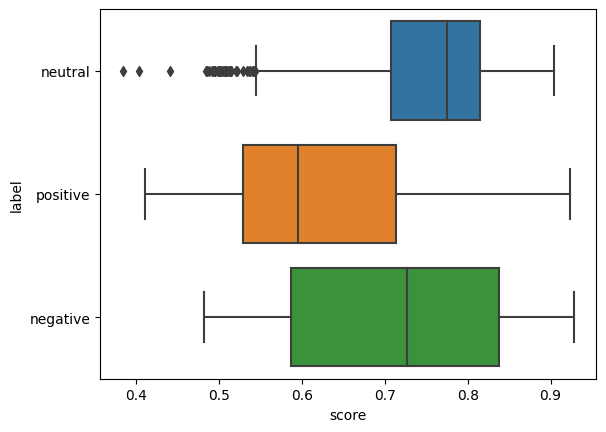

In [ ]:
sns.boxplot(spacex,x="score",y="label")

<Axes: xlabel='label', ylabel='count'>

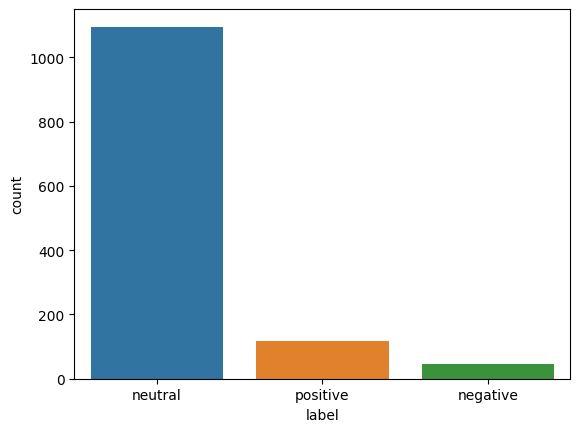

In [ ]:
sns.countplot(spacex,x="label")

# how about term frequency? 

In [ ]:
# Define the stop words to remove
stop_words = set(stopwords.words('english'))

# Convert the set to a DataFrame
stopwords_df = pd.DataFrame(list(stop_words), columns=['stopword'])
print("There are {} words in the stopword list here is a sample: \n {}".format(stopwords_df.shape[0],list(stop_words)[0:4]))


There are 179 words in the stopword list here is a sample: 
 ["haven't", 'once', 'where', 'about']


In [ ]:
# negative tweets 
space_terms = (spacex['full_text']
                     .str.lower()
                     .apply(lambda x: re.sub('\s+', ' ', x.translate(str.maketrans('', '', string.punctuation)).strip()))
                     .str.split()
                     .explode()
                     .to_frame("term")
             )

term_freq_w_junk = (space_terms
            .groupby("term")
            .size()
            .reset_index()
            .rename(columns={0: "freq"})
            .sort_values("freq", ascending=False)
            .dropna()
            .reset_index(drop=True)
            )

# Remove stop words and excludes from the DataFrame
term_freq_wo_junk = (term_freq_w_junk
             .merge(stopwords_df, how='left', left_on='term', right_on='stopword')
             .query("stopword.isna()")
             .drop(['stopword'], axis=1)
            )

term_freq_wo_junk.head(10)

,term,freq
2,falcon,551
3,launch,511
5,→,360
7,9,340
8,starlink,324
12,satellites,218
13,dragon,218
14,orbit,217
16,liftoff,198
20,stage,174


In [ ]:
afinn = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/MGTPython/main/module_9/sentiment/Afinn.csv", encoding='ISO-8859-1')

afinn_sentiment = ( term_freq_wo_junk
                    .merge(afinn, how='left', left_on='term', right_on='word')
                    .query("not value.isna()")
)
afinn_sentiment.head()

,term,freq,word,value
40,good,45,good,3.0
46,fire,41,fire,-2.0
87,love,24,love,3.0
213,allow,10,allow,1.0
226,dedicated,9,dedicated,2.0


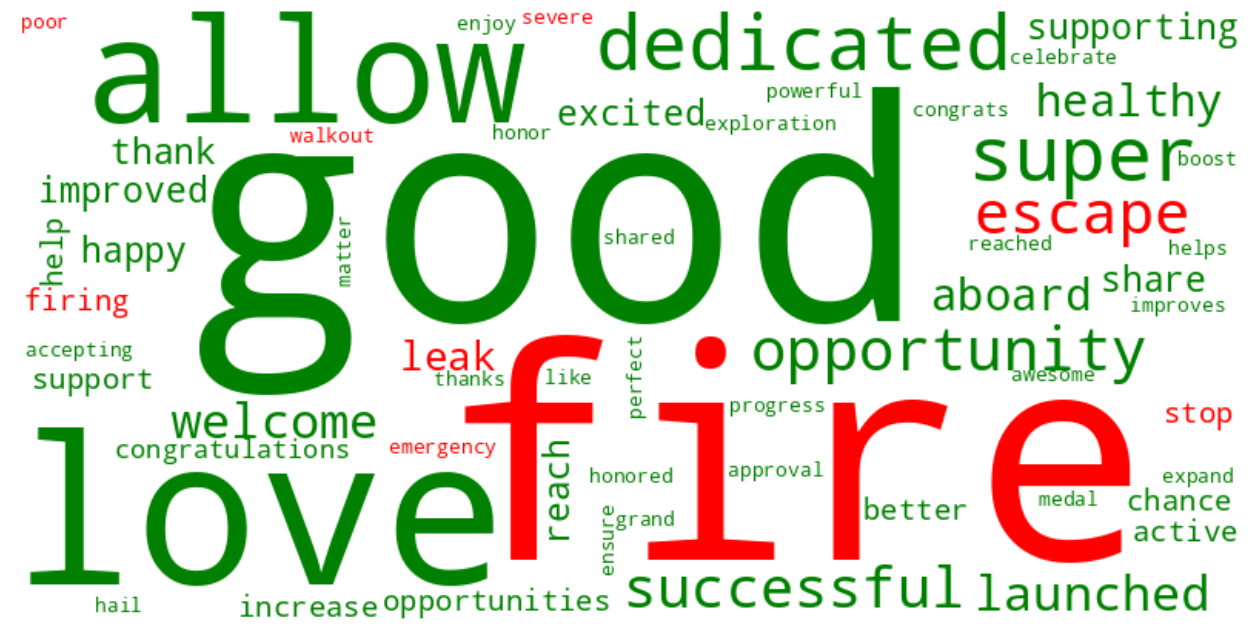

In [ ]:
# create a dictionary of term frequency counts
freq_dict = dict(zip(afinn_sentiment['term'], afinn_sentiment['freq']))

# create a dictionary of sentiment scores
sentiment_dict = dict(zip(afinn_sentiment['term'], afinn_sentiment['value']))

# create a color function that maps sentiment scores to colors
def get_color(word, *args, **kwargs):
    sentiment_score = sentiment_dict.get(word)
    if sentiment_score is not None:
        if sentiment_score > 0:
            return 'green'
        elif sentiment_score < 0:
            return 'red'
        else:
            return 'gray'
    else:
        return 'black'

# create the word cloud object
wordcloud = WordCloud(background_color='white', width=800, height=400, color_func=get_color).generate_from_frequencies(freq_dict)

# display the word cloud
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# AOC's Tweets? 


---



In [ ]:
aoc["sentiment_prediction"] = aoc['full_text'].apply(sentiment_task)

In [ ]:
# define lambda functions to extract label and score
extract_label = lambda x: x[0]['label']
extract_score = lambda x: x[0]['score']


# apply lambda functions to create new columns
aoc['label'] = aoc['sentiment_prediction'].apply(extract_label)
aoc['score'] = aoc['sentiment_prediction'].apply(extract_score)

aoc.head()

,created_at,id_str,full_text,source,sentiment_prediction,label,score
0,2023-04-06 13:49:31+00:00,1643974216696442880,This is beyond party or partisanship. This deg...,"<a href=""http://twitter.com/download/iphone"" r...","[{'label': 'negative', 'score': 0.937840878963...",negative,0.937841
1,2023-04-06 01:50:20+00:00,1643793229052100613,If a petty HOA complaint were a person https:/...,"<a href=""http://twitter.com/download/iphone"" r...","[{'label': 'neutral', 'score': 0.5046273469924...",neutral,0.504627
2,2023-04-06 01:21:34+00:00,1643785991004598273,Wishing all our Jewish neighbors in NY-14 and ...,"<a href=""http://twitter.com/download/iphone"" r...","[{'label': 'positive', 'score': 0.861618399620...",positive,0.861618
3,2023-04-05 02:57:58+00:00,1643447859457544192,He is publicly intimidating a judge and pointi...,"<a href=""http://twitter.com/download/iphone"" r...","[{'label': 'negative', 'score': 0.878555893898...",negative,0.878556
4,2023-04-04 19:48:35+00:00,1643339805147779072,Because nothing says “innocent” like threateni...,"<a href=""http://twitter.com/download/iphone"" r...","[{'label': 'negative', 'score': 0.874628901481...",negative,0.874629


<Axes: xlabel='score', ylabel='label'>

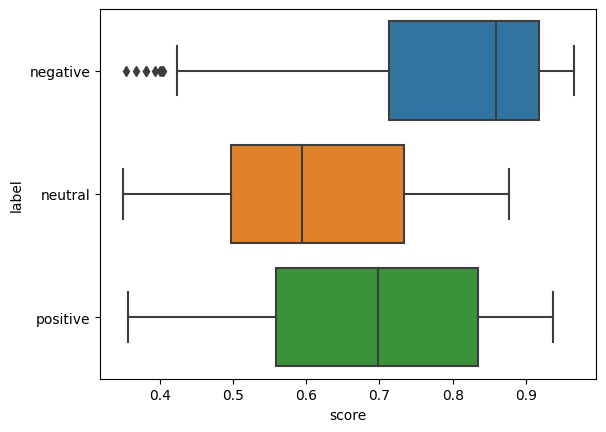

In [ ]:
sns.boxplot(aoc,x="score",y="label")

<Axes: xlabel='label', ylabel='count'>

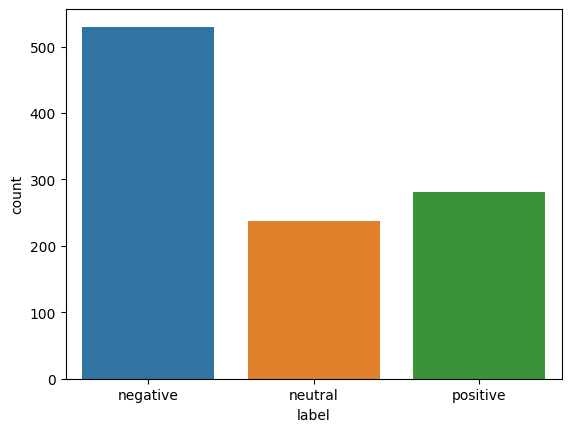

In [ ]:
sns.countplot(aoc,x="label")

In [ ]:
def get_term_freq(df):
  df_terms = (df.query('label == "negative"')['full_text']
                      .str.lower()
                      .apply(lambda x: re.sub('\s+', ' ', x.translate(str.maketrans('', '', string.punctuation)).strip()))
                      .str.split()
                      .explode()
                      .to_frame("term")
              )

  term_freq_w_junk = (df_terms
              .groupby("term")
              .size()
              .reset_index()
              .rename(columns={0: "freq"})
              .sort_values("freq", ascending=False)
              .dropna()
              .reset_index(drop=True)
              )

  # Remove stop words and excludes from the DataFrame
  term_freq_wo_junk = (term_freq_w_junk
              .merge(stopwords_df, how='left', left_on='term', right_on='stopword')
              .query("stopword.isna()")
              .drop(['stopword'], axis=1)
              )
  return term_freq_wo_junk


In [ ]:
aoc_term_freq = get_term_freq(aoc)

afinn_sentiment = ( aoc_term_freq
                    .merge(afinn, how='left', left_on='term', right_on='word')
                    .query("not value.isna()")
)
afinn_sentiment.head()

,term,freq,word,value
9,like,49,like,2.0
20,want,31,want,1.0
37,help,25,help,2.0
44,violence,23,violence,-3.0
52,stop,21,stop,-1.0


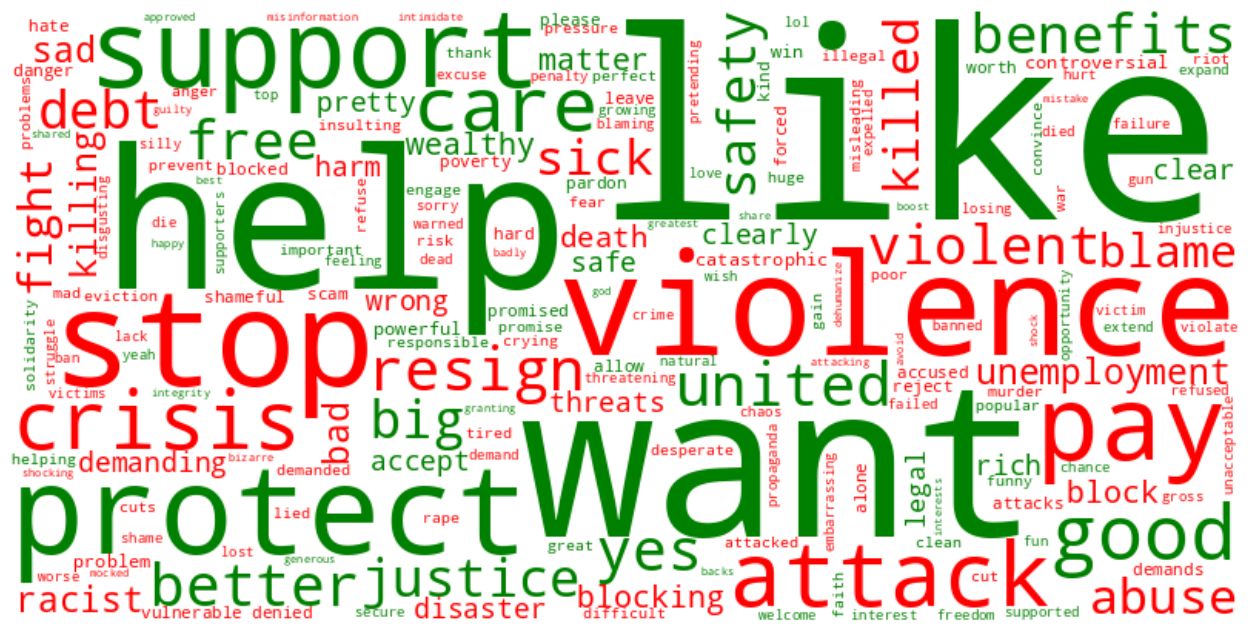

In [ ]:
# create a dictionary of term frequency counts
freq_dict = dict(zip(afinn_sentiment['term'], afinn_sentiment['freq']))

# create a dictionary of sentiment scores
sentiment_dict = dict(zip(afinn_sentiment['term'], afinn_sentiment['value']))

# create a color function that maps sentiment scores to colors
def get_color(word, *args, **kwargs):
    sentiment_score = sentiment_dict.get(word)
    if sentiment_score is not None:
        if sentiment_score > 0:
            return 'green'
        elif sentiment_score < 0:
            return 'red'
        else:
            return 'gray'
    else:
        return 'black'

# create the word cloud object
wordcloud = WordCloud(background_color='white', width=800, height=400, color_func=get_color).generate_from_frequencies(freq_dict)

# display the word cloud
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()